In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
from scipy.stats import linregress
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib.ticker import FuncFormatter, MaxNLocator
%matplotlib inline

/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Some constants
cutOffMLTMLATUniqCnt = 4

In [3]:
# Asy Inds
asyDF = pandas.read_csv( "../data/Asy_processed.txt", sep=' ' )
asyDF["date"] = pandas.to_datetime(asyDF["datetimeStr"], format='%Y%m%d-%H-%M')
asyDF["hour"] = asyDF["date"].apply(lambda x: x.strftime('%H'))
asyDF["minute"] = asyDF["date"].apply(lambda x: x.strftime('%M'))
asyDF["dtStr"] = asyDF["date"].apply(lambda x: x.strftime('%Y%m%d'))
asyDF.head()

,datetimeStr,AsyD,AsyH,SymD,SymH,date,hour,minute,dtStr
0,20110101-00-00,17.0,13.0,1.0,-10.0,2011-01-01 00:00:00,00,00,20110101
1,20110101-00-01,17.0,13.0,1.0,-10.0,2011-01-01 00:01:00,00,01,20110101
2,20110101-00-02,17.0,13.0,1.0,-10.0,2011-01-01 00:02:00,00,02,20110101
3,20110101-00-03,17.0,13.0,1.0,-10.0,2011-01-01 00:03:00,00,03,20110101
4,20110101-00-04,17.0,13.0,1.0,-10.0,2011-01-01 00:04:00,00,04,20110101


In [4]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-fin.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()
# Filter out some values
# When there aren't good number of measurements at lats
# discard those values
cntMLTPntsDF = velsDataDF[ ["dst_bin", "normMLT", "MLAT"] \
                    ].groupby( ["dst_bin", "normMLT"] \
                    )["MLAT"].nunique().reset_index()
cntMLTPntsDF.columns = ["dst_bin", "normMLT", "MLATCntUnq"]
cntMLTPntsDF = cntMLTPntsDF[ cntMLTPntsDF["MLATCntUnq"] >=\
                    cutOffMLTMLATUniqCnt ][ ["dst_bin", "normMLT"]\
                        ].reset_index(drop=True)
velsDataDF = pandas.merge( velsDataDF, cntMLTPntsDF,\
                    on=["dst_bin", "normMLT"], how="inner" )
velsDataDF["hour"] = velsDataDF["date"].apply(lambda x: x.strftime('%H'))
velsDataDF["minute"] = velsDataDF["date"].apply(lambda x: x.strftime('%M'))
velsDataDF["dtStr"] = velsDataDF["date"].apply(lambda x: x.strftime('%Y%m%d'))

In [5]:
# Also merge with aymDF
# print "pre merge shape-->", velsDataDF.shape
velsDataDF = pandas.merge( velsDataDF, asyDF,\
                         on=["dtStr", "hour", "minute"], how='inner')
velsDataDF = velsDataDF [ ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date_x','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr_x', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH'] ]
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH']

In [6]:
# Divide asymH index into bins
asyHBins = [ 0, 30, 60, 90, 180 ]
velsDataDF = pandas.concat( [ velsDataDF, \
                    pandas.cut( velsDataDF["AsyH"], \
                               bins=asyHBins ) ], axis=1 )
velsDataDF.columns = ['azim','azimStd', 'delMLT', 'goodFit',\
                      'MLAT', 'normMLT', 'vSaps', 'velSTD',\
                      'endPtMLAT', 'endPtNormMLT', 'date','dtStr',\
                      'hour', 'minute', 'dst_date', 'dst_index', 'dst_bin',\
                      'datetimeStr', 'AE', 'AL', 'AO', 'AU', 'count', 'maxCount',\
                       'probOcc', 'AsyD', 'AsyH', 'SymD', 'SymH', 'AsyH_bin']
velsDataDF["AsyH_bin"] = velsDataDF["AsyH_bin"].astype(str)

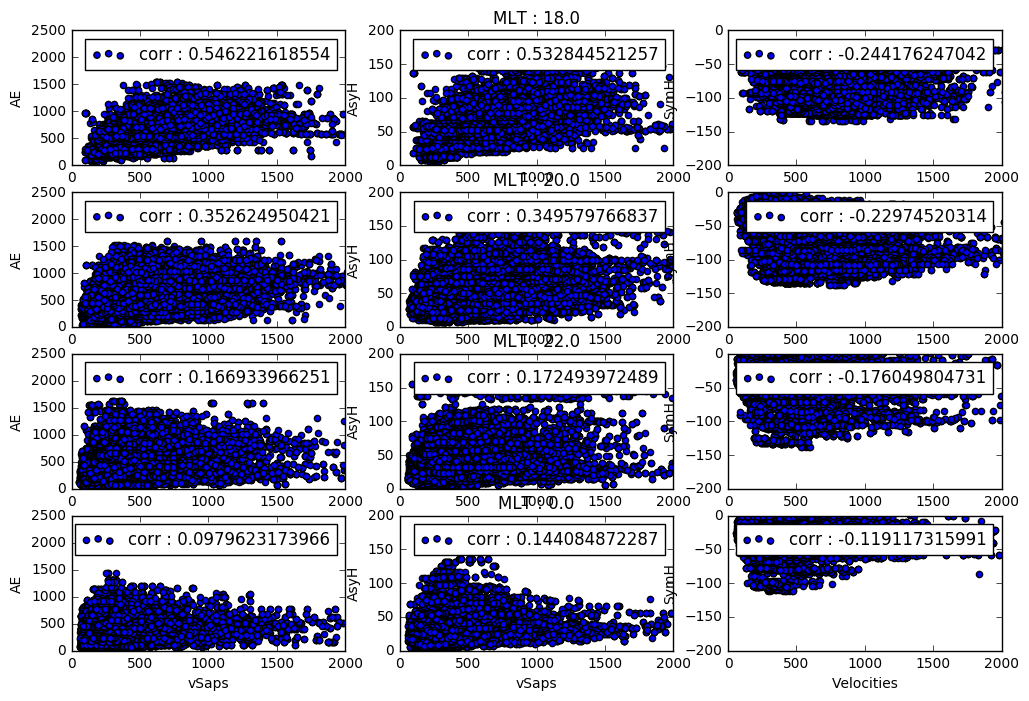

In [7]:
f = plt.figure(figsize=(12, 8))
# ax1 = f.add_subplot(1,3,1)
# ax2 = f.add_subplot(1,3,2)
# ax3 = f.add_subplot(1,3,3)

# selMltDF = velsDataDF[ velsDataDF["normMLT"] == -5 ][ ["normMLT", "AE", "AsyH", "SymH", "vSaps"] ]
# selMltDF.plot( kind="scatter", x="vSaps", y="AE", ax=ax1 )
# selMltDF.plot( kind="scatter", x="vSaps", y="AsyH", ax=ax2 )
# selMltDF.plot( kind="scatter", x="vSaps", y="SymH", ax=ax3 )

figCnt = 1
for m in sorted(velsDataDF["normMLT"].unique().tolist()):
    currDF = velsDataDF[ velsDataDF["normMLT"] == m ][ ["vSaps", "SymH", "AsyH", "AE", "dst_index"] ]
    corr = currDF.corr()
#     print "mlt-->", m
#     print "----------------"
#     print corr["vSaps"]["AsyH"]
    if ((m%2 == 0.) and (figCnt<=12)):
        ax1 = f.add_subplot(4,3,figCnt)
        figCnt += 1
        ax2 = f.add_subplot(4,3,figCnt)
        figCnt += 1
        ax3 = f.add_subplot(4,3,figCnt)
        figCnt += 1
        selMltDF = velsDataDF[ velsDataDF["normMLT"] == m ][ ["normMLT", "AE", "AsyH", "SymH", "vSaps"] ]
        selMltDF.plot( kind="scatter", x="vSaps", y="AE", ax=ax1, label="corr : " + str( corr["vSaps"]["AE"] ) )
        selMltDF.plot( kind="scatter", x="vSaps", y="AsyH", ax=ax2, label="corr : " + str( corr["vSaps"]["AsyH"] ) )
        selMltDF.plot( kind="scatter", x="vSaps", y="SymH", ax=ax3, label="corr : " + str( corr["vSaps"]["SymH"] ) )
        ax1.tick_params(labelsize=10)
        ax2.tick_params(labelsize=10)
        ax3.tick_params(labelsize=10)
        ax1.set_ylabel("AE", fontsize=10)
        ax2.set_ylabel("AsyH", fontsize=10)
        ax3.set_ylabel("SymH", fontsize=10)
        ax1.set_xlim( [0, 2000] )
        ax1.set_ylim( [0, 2500] )
        ax2.set_xlim( [0, 2000] )
        ax2.set_ylim( [0, 200] )
        ax3.set_xlim( [0, 2000] )
        ax3.set_ylim( [-200, 0] )
        if m < 0:
            ax2.set_title( "MLT : " + str(m+24), fontsize=12 )
        else:
            ax2.set_title( "MLT : " + str(m), fontsize=12 )
plt.xlabel("Velocities")
# plt.legend( fontsize = 'x-small' )
plt.rc('legend',fontsize='x-small') # using a named size

In [8]:
print velsDataDF["AsyH_bin"].unique()

['(30, 60]' '(0, 30]' '(60, 90]' '(90, 180]']


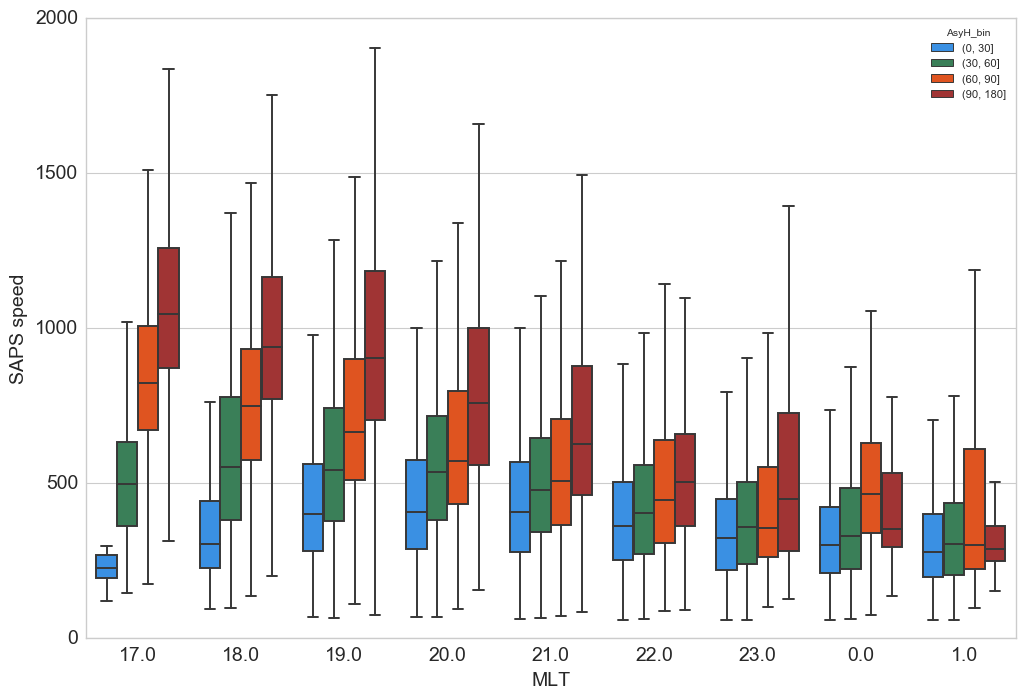

In [14]:

sns.set_style("whitegrid")
sns.set_context("paper")
# We need to plot MLTs (we are using normMLT now)
# 
colors = [ "dodgerblue", "seagreen", "orangered", "firebrick" ]
unqNrmMLTList = sorted( velsDataDF[ (velsDataDF["normMLT"] < 2.) ]["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
asy_order = [ '(0, 30]', '(30, 60]', '(60, 90]', '(90, 180]' ]
sns.boxplot( x="normMLT", y="vSaps", hue="AsyH_bin", data=velsDataDF[ (velsDataDF["normMLT"] < 2.) ],\
            hue_order=asy_order, palette=sns.color_palette(colors), showfliers=False,ax=ax1 )
ax1.set_ylim( [0, 2000] )
# plt.xticks( range(len(unqNrmMLTList)), mltStr )
ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("SAPS speed", fontsize=14)
plt.savefig("../figs/AsyH-MLT-Vels.eps",bbox_inches='tight')

In [10]:
mltVelsVarsDF = velsDataDF[ ["normMLT", "AsyH_bin", "vSaps"] \
                    ].groupby( ["normMLT", "AsyH_bin"] ).mean().reset_index()
mltVelsVarsDF.columns = ["normMLT", "AsyH_bin", "mean_vel"]
stdVelsVarsDF = velsDataDF[ ["normMLT", "AsyH_bin", "vSaps"] \
                    ].groupby( ["normMLT", "AsyH_bin"] ).std().reset_index()
stdVelsVarsDF.columns = ["normMLT", "AsyH_bin", "std_vel"]
mltVelsVarsDF = pandas.merge( mltVelsVarsDF, stdVelsVarsDF, on=["normMLT", "AsyH_bin"] )

In [11]:
def linear_func(x, slope, intrcpt):
    # we are working in degrees but numpy deals with radians
    # convert to radians
    return intrcpt + slope*x

fitDFAsyH30 = mltVelsVarsDF[ mltVelsVarsDF[ "AsyH_bin" ] == "(0, 30]" ].dropna()
fitDFAsyH60 = mltVelsVarsDF[ mltVelsVarsDF[ "AsyH_bin" ] == "(30, 60]" ].dropna()
fitDFAsyH90 = mltVelsVarsDF[ mltVelsVarsDF[ "AsyH_bin" ] == "(60, 90]" ].dropna()
fitDFAsyH180 = mltVelsVarsDF[ mltVelsVarsDF[ "AsyH_bin" ] == "(90, 180]" ].dropna()
print fitDFAsyH30
slope30, intercept30, r_value30,\
    p_value30, std_err30 = linregress(\
                fitDFAsyH30['normMLT'].T,fitDFAsyH30['mean_vel'].T )
popt30 = []
popt30.append( slope30 )
popt30.append( intercept30 )

print "AsyH 30-->", slope30, intercept30, r_value30, p_value30, std_err30

slope60, intercept60, r_value60,\
    p_value60, std_err60 = linregress(\
                fitDFAsyH60['normMLT'].T,fitDFAsyH60['mean_vel'].T )
popt60 = []
popt60.append( slope60 )
popt60.append( intercept60 )

print "AsyH 60-->", slope60, intercept60, r_value60, p_value60, std_err60


slope90, intercept90, r_value90,\
    p_value90, std_err90 = linregress(\
                fitDFAsyH90['normMLT'].T,fitDFAsyH90['mean_vel'].T )
popt90 = []
popt90.append( slope90 )
popt90.append( intercept90 )


print "AsyH 90-->", slope90, intercept90, r_value90, p_value90, std_err90

slope180, intercept180, r_value180,\
    p_value180, std_err180 = linregress(\
                fitDFAsyH180['normMLT'].T,fitDFAsyH180['mean_vel'].T )
popt180 = []
popt180.append( slope180 )
popt180.append( intercept180 )


print "AsyH 180-->", slope180, intercept180, r_value180, p_value180, std_err180


# Now get data from the fits
normMLTModel30 = range( int( numpy.min(fitDFAsyH30['normMLT']) ), int( numpy.max(fitDFAsyH30['normMLT']) ) + 1, 1)
velArrModel30 = [ round( linear_func(t, popt30[0], popt30[1]) ) for t in normMLTModel30 ]

normMLTModel60 = range( int( numpy.min(fitDFAsyH60['normMLT']) ), int( numpy.max(fitDFAsyH60['normMLT']) ) + 1, 1)
velArrModel60 = [ round( linear_func(t, popt60[0], popt60[1]) ) for t in normMLTModel60 ]

normMLTModel90 = range( int( numpy.min(fitDFAsyH90['normMLT']) ), int( numpy.max(fitDFAsyH90['normMLT']) ) + 1, 1)
velArrModel90 = [ round( linear_func(t, popt90[0], popt90[1]) ) for t in normMLTModel90 ]

normMLTModel180 = range( int( numpy.min(fitDFAsyH180['normMLT']) ), int( numpy.max(fitDFAsyH180['normMLT']) ) + 1, 1)
velArrModel180 = [ round( linear_func(t, popt180[0], popt180[1]) ) for t in normMLTModel180 ]


    normMLT AsyH_bin    mean_vel     std_vel
0      -7.0  (0, 30]  331.845416  253.345921
4      -6.0  (0, 30]  370.025255  216.551846
8      -5.0  (0, 30]  444.172416  216.749737
12     -4.0  (0, 30]  452.494247  225.152472
16     -3.0  (0, 30]  454.355496  249.365306
20     -2.0  (0, 30]  403.424412  223.518220
24     -1.0  (0, 30]  363.023579  209.649487
28      0.0  (0, 30]  341.730374  197.409432
32      1.0  (0, 30]  323.651501  197.480308
36      2.0  (0, 30]  301.319190  216.332390
40      3.0  (0, 30]  235.515814   95.801138
AsyH 30--> -13.0081334373 339.579887549 -0.625450140053 0.0395875076883 5.40932007772
AsyH 60--> -36.4304898206 371.221479475 -0.933385703868 2.70098046517e-05 4.66901838665
AsyH 90--> -36.2115553752 516.262621134 -0.803732506356 0.00508444944483 9.47765523834
AsyH 180--> -97.2279499706 416.606954902 -0.994854192004 3.04865358891e-09 3.50081425466


In [12]:
strVel30 = "Vel = " + str( int(round( popt30[1] ) ) ) + " + (" + str( int( round( popt30[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel60 = "Vel = " + str( int( round( popt60[1] ) ) ) + " + (" + str( int( round( popt60[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel90 = "Vel = " + str( int( round( popt90[1] ) ) ) + " + (" + str( int( round( popt90[0] ) ) )  + ") x $\Delta MLT_{00}$"
strVel180 = "Vel = " + str( int( round( popt180[1] ) ) ) + " + (" + str( int( round( popt180[0] ) ) )  + ") x $\Delta MLT_{00}$"

In [13]:
sns.set_style("whitegrid")
sns.set_context("poster")

mltVelsVarsDF = mltVelsVarsDF.sort(["normMLT"])
unqNrmMLTList = sorted( mltVelsVarsDF["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )
###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######

plt.scatter(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(0, 30]"],
            mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(0, 30]"],
            marker='o',
            color='dodgerblue',
            alpha=0.7,
            s = 124,
            label='(0, 30]')
plt.errorbar(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(0, 30]"],\
             mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(0, 30]"],\
             yerr=mltVelsVarsDF['std_vel'][mltVelsVarsDF['AsyH_bin'] == "(0, 30]"], \
             color='dodgerblue', label='', capthick=2., capsize=5., fmt='o')
plt.plot( normMLTModel30, velArrModel30, color='dodgerblue' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######
###### PLOT AsyH_bin (0, 30] ######


###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######

plt.scatter(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(30, 60]"],
            mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(30, 60]"],
            marker='o',
            color='seagreen',
            alpha=0.7,
            s = 124,
            label='(30, 60]')
plt.errorbar(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(30, 60]"],\
             mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(30, 60]"],\
             yerr=mltVelsVarsDF['std_vel'][mltVelsVarsDF['AsyH_bin'] == "(30, 60]"], \
             color='seagreen', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel60, velArrModel60, color='seagreen' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######
###### PLOT AsyH_bin (30, 60] ######


###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######

plt.scatter(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(60, 90]"],
            mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(60, 90]"],
            marker='o',
            color='orangered',
            alpha=0.7,
            s = 124,
            label='(60, 90]')
plt.errorbar(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(60, 90]"],\
             mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(60, 90]"],\
             yerr=mltVelsVarsDF['std_vel'][mltVelsVarsDF['AsyH_bin'] == "(60, 90]"], \
             color='orangered', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel90, velArrModel90, color='orangered' )

plt.xticks(unqNrmMLTList, mltStr, size='small')

###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######
###### PLOT AsyH_bin (60, 90] ######


plt.scatter(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(90, 180]"],
            mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(90, 180]"],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124,
            label='(90, 180]')
plt.errorbar(mltVelsVarsDF['normMLT'][mltVelsVarsDF['AsyH_bin'] == "(90, 180]"],\
             mltVelsVarsDF['mean_vel'][mltVelsVarsDF['AsyH_bin'] == "(90, 180]"],\
             yerr=mltVelsVarsDF['std_vel'][mltVelsVarsDF['AsyH_bin'] == "(90, 180]"], \
             color='firebrick', label='', capthick=2., capsize=5., fmt='o')

plt.plot( normMLTModel180, velArrModel180, color='firebrick' )

plt.xticks(unqNrmMLTList, mltStr, size='small')


plt.text(-2., 1500., strVel180, fontsize=15, color='firebrick')
plt.text(-2., 1400., strVel90, fontsize=15, color='orangered')
plt.text(-2., 1300., strVel60, fontsize=15, color='seagreen')
plt.text(-2., 1200., strVel30, fontsize=15, color='dodgerblue')


plt.xlabel("MLT", fontsize=14)
plt.ylabel("Mean Velocities", fontsize=14)

plt.legend()
plt.savefig("../figs/AE-MLT-Vels-meanstd.pdf",bbox_inches='tight')

AttributeError: 'DataFrame' object has no attribute 'sort'

In [ ]:

# We need to plot MLTs (we are using normMLT now)
# 
unqNrmMLTList = sorted( velsDataDF[ (velsDataDF["normMLT"] < 2.) ]["normMLT"].unique().tolist() )
mltStr = []
for j in unqNrmMLTList:
    if j < 0:
        mltStr.append( str(j + 24) )
    else:
        mltStr.append( str(j) )

f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(1,1,1)
asy_order = [ '(0, 30]', '(30, 60]', '(60, 90]', '(90, 180]' ]

normMLTModel30 = numpy.array( [ float(x) if x < 2. else numpy.nan for x in normMLTModel30 ] )
normMLTModel60 = numpy.array( [ float(x) if x < 2. else numpy.nan for x in normMLTModel60 ] )
normMLTModel90 = numpy.array( [ float(x) if x < 2. else numpy.nan for x in normMLTModel90 ] )
normMLTModel180 = numpy.array( [ float(x) if x < 2. else numpy.nan for x in normMLTModel180 ] )

# sns.pointplot(x=normMLTModel180, y=numpy.array(velArrModel180), linestyles=":", scale=0.5, ax=ax1)
# sns.pointplot(x=normMLTModel90, y=numpy.array(velArrModel90), linestyles=":", scale=0.5, ax=ax1)
# sns.pointplot(x=normMLTModel60, y=numpy.array(velArrModel60), linestyles=":", scale=0.5, ax=ax1)
# sns.pointplot(x=normMLTModel30, y=numpy.array(velArrModel30), linestyles=":", scale=0.5, ax=ax1)


sns.boxplot( x="normMLT", y="vSaps", hue="AsyH_bin", data=velsDataDF[ (velsDataDF["normMLT"] < 2.) ],\
            hue_order=asy_order, palette="Spectral_r", showfliers=False,ax=ax1 )



ax1.set_xticklabels( mltStr )
ax1.tick_params(labelsize=14)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Velocities", fontsize=14)
plt.savefig("../figs/AsyH-MLT-Vels.pdf",bbox_inches='tight')

In [ ]:
# Groupby Asy bin
AsyCntDF = velsDataDF.groupby( [ "AsyH_bin", "normMLT", "MLAT" ] ).size().reset_index()
AsyCntDF.columns = [ "AsyH_bin", "normMLT", "MLAT", "cnt" ]
AsyCntDF = AsyCntDF[ AsyCntDF["cnt"] >= 50. ].reset_index(drop=True)
asyDF = velsDataDF.groupby( [ "AsyH_bin", "normMLT", "MLAT" ] ).median().reset_index()
asyDF = pandas.merge( asyDF, AsyCntDF, on=[ "AsyH_bin", "normMLT", "MLAT" ] )
asyDF = asyDF.rename(columns={'vSaps': 'SAPS speed [m/s]'})
asyDF.head()

In [ ]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(2,2,4)
ax2 = f.add_subplot(2,2,3)
ax3 = f.add_subplot(2,2,2)
ax4 = f.add_subplot(2,2,1)

xlim = [-9,4]

def format_mlt_normMLT_ticks(tick_val, tick_pos):
    if tick_val < 0:
        return str(tick_val + 24)
    else:
        return str(tick_val)
# Now setup a velocity scale
velScaleMin = 0.
velScaleMax = 1200.
# round off max velocity to the next hundred
# velScaleMax = (asyDF["SAPS speed [m/s]"].max() + 100.)*100/100\
#     - (asyDF["SAPS speed [m/s]"].max() + 100.)%100

# Seaborn styling# OrRd
sns.set_style("whitegrid")
sns.set_context("paper")

colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]

seaMap = ListedColormap(sns.color_palette(colors))

fitResultsDF15075 = asyDF[ asyDF["AsyH_bin"] == '(90, 180]' ]     

    
fitResultsDF15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='SAPS speed [m/s]',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)
ax1.set_xlabel("MLT", fontsize=12)
ax1.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
# ax1.set_xlim(xlim)
ax1.set_ylabel("Magn. Latitude", fontsize=12)
# ax1.set_title( "AsyH between 90 & 180", fontsize=14 )
ax1.text(-2.2, 62., "90<AsyH<=180", fontsize=10, color='black')

plotMLTends = fitResultsDF15075['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF15075['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF15075['normMLT'].tolist()
plotMLATbegins = fitResultsDF15075['MLAT'].tolist()
plotVelMagns = fitResultsDF15075['SAPS speed [m/s]'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        

fitResultsDF7550 = asyDF[ asyDF["AsyH_bin"] == '(60, 90]' ]     
fitResultsDF7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='SAPS speed [m/s]',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)

plotMLTends = fitResultsDF7550['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF7550['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF7550['normMLT'].tolist()
plotMLATbegins = fitResultsDF7550['MLAT'].tolist()
plotVelMagns = fitResultsDF7550['SAPS speed [m/s]'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax2.set_xlabel("MLT", fontsize=12)
ax2.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
# ax2.set_xlim(xlim)
ax2.set_ylabel("Magn. Latitude", fontsize=12)
# ax2.set_title( "AsyH between 60 & 90", fontsize=14 )
ax2.text(-1.1, 62., "60<AsyH<=90", fontsize=10, color='black')


fitResultsDF5025 = asyDF[ asyDF["AsyH_bin"] == '(30, 60]' ]     
fitResultsDF5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='SAPS speed [m/s]',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)

plotMLTends = fitResultsDF5025['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF5025['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF5025['normMLT'].tolist()
plotMLATbegins = fitResultsDF5025['MLAT'].tolist()
plotVelMagns = fitResultsDF5025['SAPS speed [m/s]'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax3.set_xlabel("MLT", fontsize=12)
ax3.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))
# ax3.set_xlim(xlim)
ax3.set_ylabel("Magn. Latitude", fontsize=12)
# ax3.set_title( "AsyH between 30 & 60", fontsize=14 )
ax3.text(-0.3, 64., "30<AsyH<=60", fontsize=10, color='black')


        
        
fitResultsDF2510 = asyDF[ asyDF["AsyH_bin"] == '(0, 30]' ]     
fitResultsDF2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='SAPS speed [m/s]',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax4)


plotMLTends = fitResultsDF2510['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF2510['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF2510['normMLT'].tolist()
plotMLATbegins = fitResultsDF2510['MLAT'].tolist()
plotVelMagns = fitResultsDF2510['SAPS speed [m/s]'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax4.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax4.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)


ax4.set_xlabel("MLT", fontsize=12)
ax4.xaxis.set_major_formatter(FuncFormatter(format_mlt_normMLT_ticks))     
# ax4.set_xlim(xlim)
ax4.set_ylabel("Magn. Latitude", fontsize=12)
# ax4.set_title( "AsyH between 0 & 30", fontsize=14 ) 
ax4.text(1., 64., "0<AsyH<=30", fontsize=10, color='black')

plt.savefig("../figs/asyhBinsVelVecs.pdf",bbox_inches='tight')

In [ ]:
# colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
# colors = [ "#91bfdb", "#3182bd", "#a1d76a", "#5ab4ac", "#fc8d59", "#e6550d" ]
colors = [ "#2c7fb8", "#41b6c4", "#2ca25f", "#feb24c", "#fd8d3c", "#e6550d" ]
# sns.palplot(sns.xkcd_palette(colors))
sns.palplot(sns.color_palette(colors))